In [1]:
import zipfile
path = "drive/MyDrive/train.zip"
f = zipfile.ZipFile(path)
f.extractall()

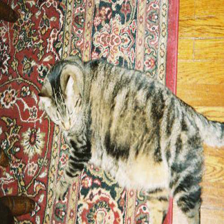

In [2]:
import glob
from PIL import Image
fs = glob.glob("train/*")
Image.open(fs[120]).resize((224, 224)).convert("RGB")

In [3]:
import pandas as pd
dog = glob.glob("train/dog.*")
cat = glob.glob("train/cat.*")
datas = pd.DataFrame({
    "path":dog + cat,
    "ans":[0]* len(dog) + [1]* len(cat)
})
datas

,path,ans
0,train/dog.8583.jpg,0
1,train/dog.3491.jpg,0
2,train/dog.1382.jpg,0
3,train/dog.2551.jpg,0
4,train/dog.10178.jpg,0
...,...,...
24995,train/cat.11015.jpg,1
24996,train/cat.11721.jpg,1
24997,train/cat.4982.jpg,1
24998,train/cat.11511.jpg,1


In [4]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
# 取出每一層
vgg_layers = vgg.layers
for l in vgg_layers:
    l.trainable = False
clf_layers = [
    BatchNormalization(),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.25),
    Dense(2, activation="softmax")
]
model = Sequential(vgg_layers + clf_layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [6]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(), 
       optimizer="adam",
       metrics=["accuracy"])

In [7]:
# demo pre: 遇處理需要與當初相同
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
img = Image.open(fs[5000]).resize((224, 224)).convert("RGB")
img_np = np.array(img)
preprocess_input(img_np)

array([[[ -8.939003 , -17.779    , -23.68     ],
        [ -7.939003 , -16.779    , -22.68     ],
        [-12.939003 , -22.779    , -26.68     ],
        ...,
        [-46.939003 , -55.779    , -61.68     ],
        [-46.939003 , -55.779    , -61.68     ],
        [-47.939003 , -56.779    , -62.68     ]],

       [[-19.939003 , -28.779    , -34.68     ],
        [-11.939003 , -20.779    , -26.68     ],
        [ -4.939003 , -14.778999 , -18.68     ],
        ...,
        [-45.939003 , -54.779    , -60.68     ],
        [-45.939003 , -54.779    , -60.68     ],
        [-46.939003 , -55.779    , -61.68     ]],

       [[-25.939003 , -34.779    , -40.68     ],
        [ -9.939003 , -18.779    , -24.68     ],
        [ -2.939003 , -11.778999 , -16.68     ],
        ...,
        [-45.939003 , -54.779    , -60.68     ],
        [-45.939003 , -54.779    , -60.68     ],
        [-44.939003 , -53.779    , -59.68     ]],

       ...,

       [[ -5.939003 , -14.778999 , -16.68     ],
        [ -

In [8]:
x, y = np.array(datas["path"]), np.array(datas["ans"])

In [9]:
# x,y= 資料來源 / batch= 圖片讀取量
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), size=batch)
    y_batch = y[idx]
    x_batch, x_batch_ori = [], []
    for p in x[idx]:
        img = Image.open(p).resize((224, 224)).convert("RGB")
        img_np = np.array(img) 
        img_np_pre = preprocess_input(img_np)
        x_batch.append(img_np_pre)
        x_batch_ori.append(img_np)
    return (np.array(x_batch), np.array(y_batch), np.array(x_batch_ori))
x_batch, y_batch, x_batch_ori = get_data(x, y)
print(x_batch.shape)
print(y_batch.shape)
print(x_batch_ori.shape)

(20, 224, 224, 3)
(20,)
(20, 224, 224, 3)


In [10]:
# train_on_batch, test_on_batch
for i in range(20):
  print("-" * 15 , i , "-" * 15)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.train_on_batch(x_batch, y_batch)
  print("Train:", result)
  x_batch, y_batch, x_batch_ori = get_data(x, y)
  result = model.test_on_batch(x_batch, y_batch)
  print("Test:", result)

--------------- 0 ---------------
Train: [0.835223376750946, 0.6000000238418579]
Test: [5.0323896408081055, 0.8500000238418579]
--------------- 1 ---------------
Train: [0.5662985444068909, 0.800000011920929]
Test: [7.384146213531494, 0.8999999761581421]
--------------- 2 ---------------
Train: [0.3811191916465759, 0.800000011920929]
Test: [0.00027077653794549406, 1.0]
--------------- 3 ---------------
Train: [0.5058977007865906, 0.8500000238418579]
Test: [0.2501271367073059, 0.949999988079071]
--------------- 4 ---------------
Train: [0.18999125063419342, 0.8500000238418579]
Test: [2.995591402053833, 0.8999999761581421]
--------------- 5 ---------------
Train: [0.482205867767334, 0.8999999761581421]
Test: [0.0012635511811822653, 1.0]
--------------- 6 ---------------
Train: [1.2542955875396729, 0.800000011920929]
Test: [1.5194483995437622, 0.8999999761581421]
--------------- 7 ---------------
Train: [0.46368059515953064, 0.8500000238418579]
Test: [0.8551285862922668, 0.800000011920929

In [13]:
  x_batch, y_batch, x_batch_ori = get_data(x, y, 2000)
model.evaluate(x_batch, y_batch)

63/63 [==============================] - 9s 91ms/step - loss: 2.4314 - accuracy: 0.9260


[2.4314444065093994, 0.9259999990463257]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


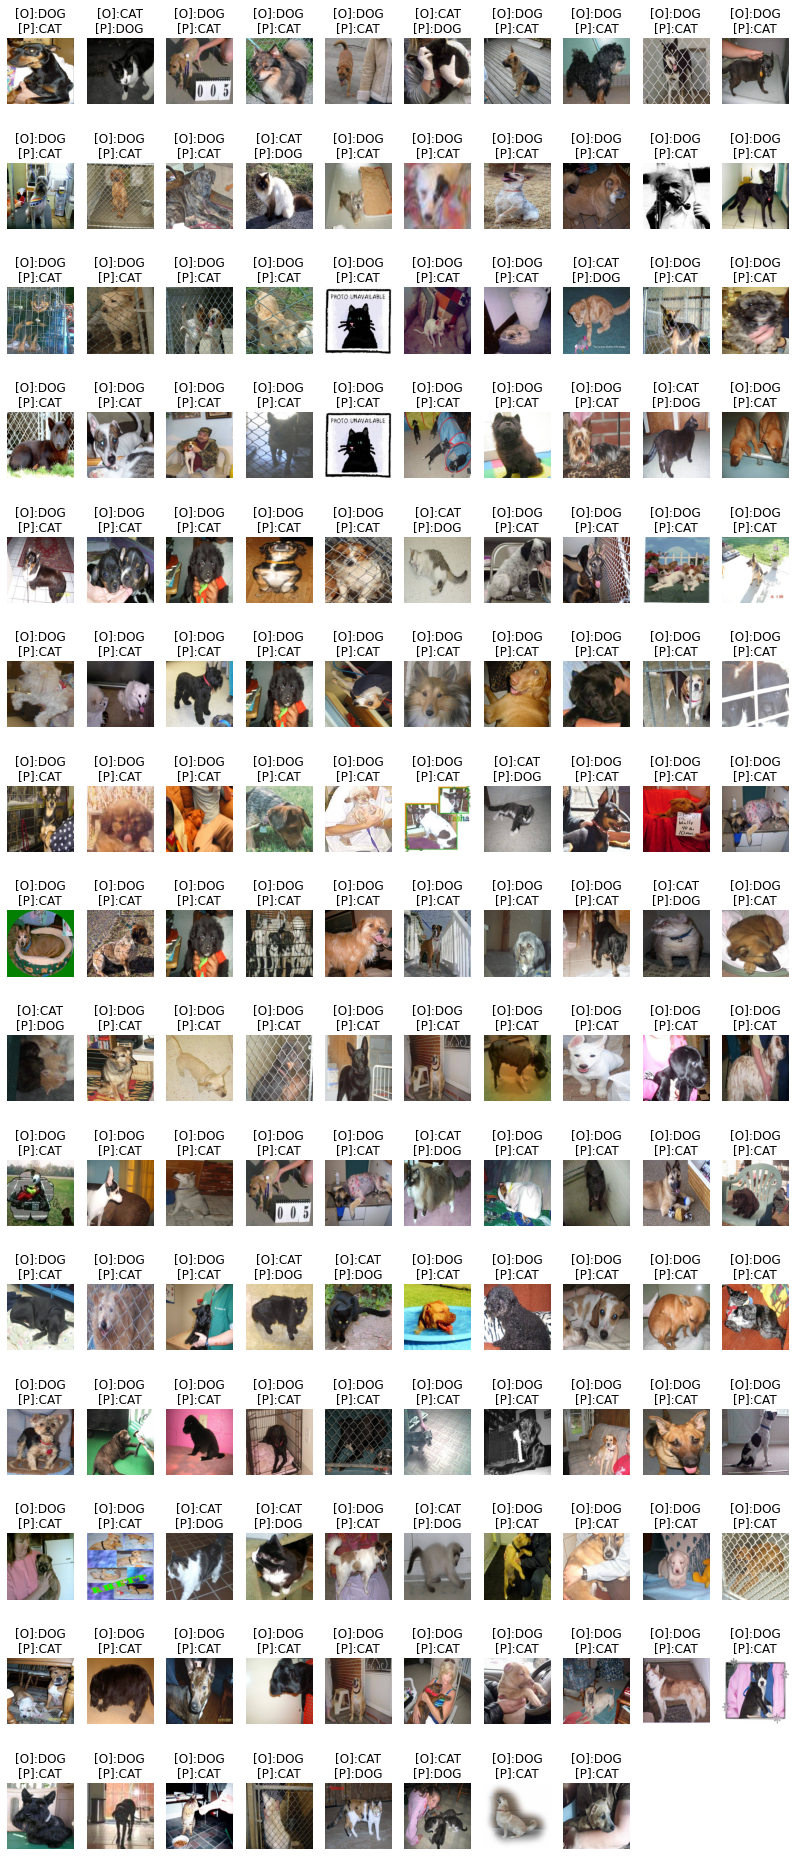

In [16]:
import numpy as np
import matplotlib.pyplot as plt
pre = model.predict_classes(x_batch)
trans = ["DOG", "CAT"]
idx = np.nonzero(pre != y_batch)[0][:200]
false_img = x_batch_ori[idx]
false_pre = pre[idx]
false_label = y_batch[idx]
plt.figure(figsize=(14, 34))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[false_label[i]], trans[false_pre[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(false_img[i])